<a href="https://colab.research.google.com/github/fikrilearnstocode/Kecerdasan-Komputasional-dan-Pembelajaran-Mesin/blob/main/Tugas_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Block 1 - Instalasi Library**

In [ ]:
pip install ucimlrepo

#**Block 2 - Load & Explore Dataset**

In [ ]:
from ucimlrepo import fetch_ucirepo
import pandas as pd

car_evaluation = fetch_ucirepo(id=19)

X = car_evaluation.data.features
y = car_evaluation.data.targets

if isinstance(y, pd.DataFrame):
    y = y.iloc[:, 0]

print("X shape:", X.shape)
print("y shape:", y.shape)
print("y classes:", y.unique())
X.head()

X shape: (1728, 6)
y shape: (1728,)
y classes: ['unacc' 'acc' 'vgood' 'good']


,buying,maint,doors,persons,lug_boot,safety
0,vhigh,vhigh,2,2,small,low
1,vhigh,vhigh,2,2,small,med
2,vhigh,vhigh,2,2,small,high
3,vhigh,vhigh,2,2,med,low
4,vhigh,vhigh,2,2,med,med


#**Block 3 - Encoding Label**

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_enc = le.fit_transform(y)

print("Label mapping (encoded -> original):")
for i, cls in enumerate(le.classes_):
    print(i, "->", cls)

Label mapping (encoded -> original):
0 -> acc
1 -> good
2 -> unacc
3 -> vgood


#**Block 4 - Train-Test Split**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_enc,
    test_size=0.2,
    random_state=42,
    stratify=y_enc,
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (1382, 6) Test: (346, 6)


#**Block 5 - Preprocessing Fitur Kategorikal**

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

categorical_features = X.columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ],
    remainder="drop",
)

#**Block 6 - Model MLP**

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier

baseline_mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    learning_rate_init=1e-3,
    max_iter=300,
    early_stopping=True,
    n_iter_no_change=10,
    random_state=42,
)

baseline_clf = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", baseline_mlp),
    ]
)

baseline_clf

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['buying', 'maint', 'doors',
                                                   'persons', 'lug_boot',
                                                   'safety'])])),
                ('model',
                 MLPClassifier(early_stopping=True, hidden_layer_sizes=(64, 32),
                               max_iter=300, random_state=42))])

#**Block 7 - Baseline Training**

In [ ]:
baseline_clf.fit(X_train, y_train)

print("Baseline training finished.")
print("Iterations:", baseline_clf.named_steps["model"].n_iter_)
print("Loss:", baseline_clf.named_steps["model"].loss_)

Baseline training finished.
Iterations: 54
Loss: 0.07157476616400929


#**Block 8 - Evaluasi Model Baseline**

In [ ]:
from sklearn.metrics import classification_report

baseline_pred = baseline_clf.predict(X_test)

print("=== BASELINE: Prediction + Classification Report ===")
print(
    classification_report(
        le.inverse_transform(y_test),
        le.inverse_transform(baseline_pred),
        labels=le.classes_,
    )
)

=== BASELINE: Prediction + Classification Report ===
              precision    recall  f1-score   support

         acc       0.91      0.96      0.94        77
        good       0.92      0.79      0.85        14
       unacc       0.99      1.00      0.99       242
       vgood       1.00      0.77      0.87        13

    accuracy                           0.97       346
   macro avg       0.96      0.88      0.91       346
weighted avg       0.97      0.97      0.97       346



#**Block 9 - Hyperparameter Tuning**

=== BASELINE: Confusion Matrix ===


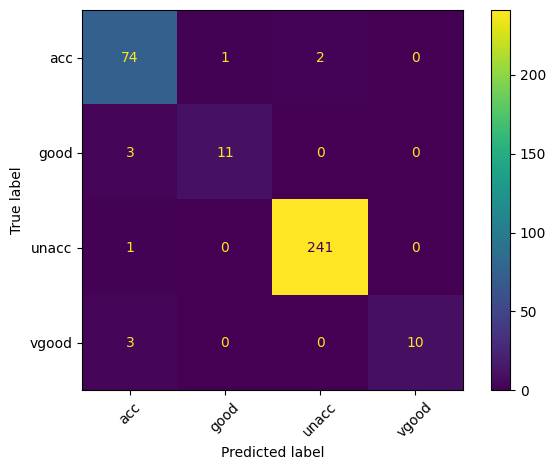

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("=== BASELINE: Confusion Matrix ===")
ConfusionMatrixDisplay.from_predictions(
    le.inverse_transform(y_test),
    le.inverse_transform(baseline_pred),
    xticks_rotation=45,
)
plt.tight_layout()
plt.show()

#**Block 10 - Pelatihan dan Evaluasi Model Terbaik**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

param_dist = {
    "model__hidden_layer_sizes": [(32,), (64,), (64, 32), (128, 64), (128, 64, 32)],
    "model__activation": ["relu", "tanh"],
    "model__alpha": np.logspace(-6, -2, 30),
    "model__learning_rate_init": np.logspace(-4, -2, 30),
}

search = RandomizedSearchCV(
    estimator=baseline_clf,
    param_distributions=param_dist,
    n_iter=25,
    scoring="f1_macro",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1,
)

search.fit(X_train, y_train)

print("Best params:", search.best_params_)
print("Best CV f1_macro:", search.best_score_)

best_clf = search.best_estimator_

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best params: {'model__learning_rate_init': np.float64(0.006210169418915616), 'model__hidden_layer_sizes': (128, 64), 'model__alpha': np.float64(0.005298316906283708), 'model__activation': 'tanh'}
Best CV f1_macro: 0.9407199860012142


#**Block 11 - Visualisasi Perbandingan Performa**

In [ ]:
from sklearn.metrics import classification_report

best_pred = best_clf.predict(X_test)

print("=== BEST (TUNED): Prediction + Classification Report ===")
print(
    classification_report(
        le.inverse_transform(y_test),
        le.inverse_transform(best_pred),
        labels=le.classes_,
    )
)

=== BEST (TUNED): Prediction + Classification Report ===
              precision    recall  f1-score   support

         acc       0.97      0.96      0.97        77
        good       0.93      1.00      0.97        14
       unacc       0.99      1.00      0.99       242
       vgood       1.00      0.92      0.96        13

    accuracy                           0.99       346
   macro avg       0.97      0.97      0.97       346
weighted avg       0.99      0.99      0.99       346



#**Block 12**

=== BEST (TUNED): Confusion Matrix ===


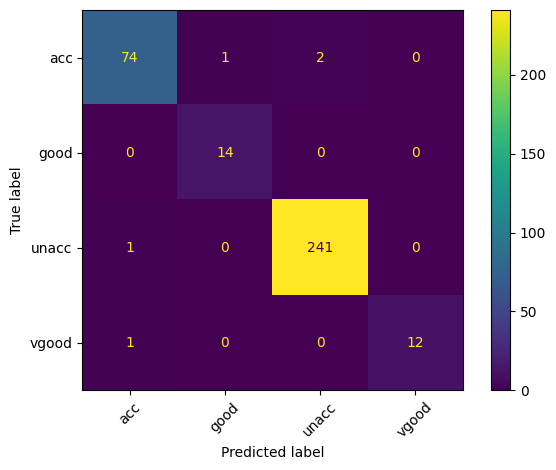

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("=== BEST (TUNED): Confusion Matrix ===")
ConfusionMatrixDisplay.from_estimator(
    best_clf,
    X_test,
    y_test,
    display_labels=le.classes_,
    xticks_rotation=45,
)
plt.tight_layout()
plt.show()

#**Block 13**

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

baseline_pred = baseline_clf.predict(X_test)
best_pred = best_clf.predict(X_test)

baseline_rep = classification_report(
    le.inverse_transform(y_test),
    le.inverse_transform(baseline_pred),
    labels=le.classes_,
    output_dict=True,
)

best_rep = classification_report(
    le.inverse_transform(y_test),
    le.inverse_transform(best_pred),
    labels=le.classes_,
    output_dict=True,
)

rows = list(le.classes_) + ["macro avg", "weighted avg"]
metrics = ["precision", "recall", "f1-score"]

baseline_df = pd.DataFrame(baseline_rep).T.loc[rows, metrics]
best_df = pd.DataFrame(best_rep).T.loc[rows, metrics]

comparison = pd.concat(
    {
        "baseline": baseline_df,
        "tuned": best_df,
        "delta(tuned-baseline)": best_df - baseline_df,
    },
    axis=1,
)

pd.options.display.float_format = "{:.3f}".format

print("=== COMPARISON: Baseline vs Tuned ===")
display(comparison)

print("\nAccuracy baseline:", baseline_rep["accuracy"])
print("Accuracy tuned   :", best_rep["accuracy"])
print("Delta accuracy   :", best_rep["accuracy"] - baseline_rep["accuracy"])

=== COMPARISON: Baseline vs Tuned ===


baseline                     tuned                  \
             precision recall f1-score precision recall f1-score   
acc              0.914  0.961    0.937     0.974  0.961    0.967   
good             0.917  0.786    0.846     0.933  1.000    0.966   
unacc            0.992  0.996    0.994     0.992  0.996    0.994   
vgood            1.000  0.769    0.870     1.000  0.923    0.960   
macro avg        0.956  0.878    0.912     0.975  0.970    0.972   
weighted avg     0.972  0.971    0.970     0.986  0.986    0.986   

             delta(tuned-baseline)                  
                         precision recall f1-score  
acc                          0.060  0.000    0.031  
good                         0.017  0.214    0.119  
unacc                        0.000  0.000    0.000  
vgood                        0.000  0.154    0.090  
macro avg                    0.019  0.092    0.060  
weighted avg                 0.014  0.014    0.015


Accuracy baseline: 0.9710982658959537
Accuracy tuned   : 0.9855491329479769
Delta accuracy   : 0.014450867052023142
